# Содержание

[1. Открытие файла с данными и изучение общей информации](#intro)

[2. Предобработка данных](#intro1)

  - [2.1 Замена типа данных](#intro2)
  - [2.2 Обработка дубликатов](#intro3)

[3. Расчёты и добавление результатов в таблицу](#intro4)

[4. Анализ данных](#intro5)

[5. Проверка гипотез](#intro6)

[Общий вывод](#intro7)

# Определение перспективного тарифа для телеком-компании

Клиентам компании «Мегалайн» — федерального оператора сотовой связи предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

**Тариф «Смарт»**  
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**  
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**  
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

 ## 1. Открытие файлов с данными и изучение общей информации               <a id='intro'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st

In [2]:
df_users = pd.read_csv('users.csv')

Выведем первые 5 строк датасета `df_users`

In [3]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Посмотрим общую информацию о данных в датасете `df_users`

In [4]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Посмотрим нет ли в данных артефактов с помощью метода `describe()`

In [5]:
df_users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Согласно документации к данным:

- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tarif` — название тарифного плана

Артефактов в датасете `df_users` не обнаружено. Есть пропуски в столбце `churn_date`, которые обозначают что тариф еще действовал на момент выгрузки данных.    
В таблице 8 столбцов. Есть такие типы данных как: `int64` и `object`.

In [6]:
df_calls = pd.read_csv('calls.csv')

Выведем первые 5 строк датасета `df_calls`

In [7]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Посмотрим общую информацию о данных в датасете `df_calls`

In [8]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Посмотрим нет ли в данных артефактов с помощью метода `describe()`

In [9]:
df_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Согласно документации к данным:

- `id` - уникальный номер звонка
- `call_date` - дата звонка
- `duration` - длительность звонка в минутах
- `user_id` - идентификатор пользователя, сделавшего звонок

Пропусков и артефактов в датасете `df_calls` не обнаружено.  
В таблице 4 столбца. Есть такие типы данных как: `int64`, `float64` и `object`

In [10]:
df_messages = pd.read_csv('messages.csv')

Выведем первые 5 строк датасета `df_messages`

In [11]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Посмотрим общую информацию о данных в датасете `df_messages`

In [12]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Посмотрим нет ли в данных артефактов с помощью метода `describe()`

In [13]:
df_messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


Согласно документации к данным:

- `id` - уникальный номер сообщения
- `message_date` - дата сообщения
- `user_id` - идентификатор пользователя, отправившего сообщение

Пропусков и артефактов в датасете `df_messages` не обнаружено.  
В таблице 3 столбца. Есть такие типы данных как: `int64` и `object`

In [14]:
df_internet = pd.read_csv('internet.csv')

Выведем первые 5 строк датасета `df_internet`

In [15]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Посмотрим общую информацию о данных в датасете `df_internet`

In [16]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Посмотрим нет ли в данных артефактов с помощью метода `describe()`

In [17]:
df_internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


Согласно документации к данным:

- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Пропусков и артефактов в датасете `df_internet` не обнаружено.	
Итак, в таблице 5 столбцов. Обнаружен столбец `Unnamed: 0` отсутствующий в документации. Этот столбец обозначает дополнительную цифровую индексацию строк. Как он попал в датасет неизвестно, возможно техническая ошибка. Этот столбец нам не пригодится и далее его можно удалить. В датасете есть такие типы данных как: `int64`, `float64` и `object`.

In [18]:
df_tariffs = pd.read_csv('tariffs.csv')

Выведем первые 5 строк датасета `df_tariffs`

In [19]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Посмотрим общую информацию о данных в датасете `df_tariffs`.

In [20]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Согласно документации к данным:

- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Пропусков и артефактов в датасете `df_tariffs` не обнаружено.  
В таблице 8 столбцов. Есть такие типы данных как: `int64` и `object`

### Вывод

Для исследования доступны 5 таблиц. В каждой строке первой таблицы — данные о пользователях. Часть колонок описывает личные данные пользователя, остальные данные говорят о используемом тарифе и датах подключения/отключения. В каждой строке второй таблицы - информация о звонках. Присутствуют данные о звонках и идентификатор пользователя. В каждой строке третьей таблицы - информация о сообщениях. В колонках данные о сообщении и идентификатор пользователя. В каждой строке четвертой таблицы - информация об интернет-сессиях. В колонках данные о интернет-сессии и идентификатор пользователя. В каждой строке пятой таблицы - информация о тарифах. 

Пропусков и артефактов в датасетах не обнаружено, предварительно можно утверждать, что данных достаточно для нашего исследования.

## 2. Предобработка данных                                                                <a id='intro1'></a>   

### 2.1 Замена типа данных                                                                                                        <a id='intro2'></a>

В столбцах `churn_date`, `reg_date` датасета `df_users` тип данных переведем в объекты `datetime` на более удобный тип для даты. В параметре `format=` укажем строку, соответствующую текущему формату `date_time`, с помощью специальных обозначений.
Выведем на экран первые пять строк `df_users`, чтобы проверить, что получилось.

In [21]:
for column in ['reg_date', 'churn_date']:
    df_users[column] = pd.to_datetime(df_users[column], format='%Y-%m-%d', errors='ignore')
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Посмотрим использование памяти в датасете `df_calls` с помощью метода `info` в котором установим параметр `memory_usage` в значение `deep`.

In [22]:
df_calls.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6 MB


Выведем максимальные и минимальные значения столбцов с помощью метода `agg()` для того, что понять в какой тип данных можно перевести столбцы.

In [23]:
df_calls.agg(['min', 'max'])

,id,call_date,duration,user_id
min,1000_0,2018-01-01,0.0,1000
max,1499_99,2018-12-31,38.0,1499


В некоторых столбцах заменим тип данных, это в том числе сэкономит использование памяти:
- в столбце `call_date` тип данных переведем в объекты `datetime` на более удобный тип для даты;
- в столбце `user_id` тип данных переведем на `int16`, т.к. максимальное значение столбца целое число 1499;
- в столбце `duration` тип данных переведем на `float32`, т.к. максимальное значение столбца вещественное число 38.0;

In [24]:
df_calls.call_date = pd.to_datetime(df_calls.call_date, format='%Y-%m-%d')
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


С помощью метода `astype` выполним замену типов данных в столбцах. 

In [25]:
df_calls = df_calls.astype({'user_id':'int16',
                    'duration':'float32'}) 

Посмотрим как изменились типы данных в столбцах в датасете `df_calls` и использование памяти.

In [26]:
df_calls.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float32       
 3   user_id    202607 non-null  int16         
dtypes: datetime64[ns](1), float32(1), int16(1), object(1)
memory usage: 15.2 MB


Использование памяти в датасете `df_calls`упало практически в два раза.

Далее посмотрим использование памяти в датасете `df_messages` с помощью метода `info` в котором установим параметр `memory_usage` в значение `deep`.

In [27]:
df_messages.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 16.4 MB


Выведем максимальные и минимальные значения столбцов с помощью метода `agg()` для того, что понять в какой тип данных можно перевести столбцы.

In [28]:
df_messages.agg(['min', 'max'])

,id,message_date,user_id
min,1000_0,2018-01-02,1000
max,1499_99,2018-12-31,1499


В некоторых столбцах заменим тип данных, это в том числе сэкономит использование памяти:
- в столбце `message_date` тип данных переведем в объекты `datetime` на более удобный тип для даты;
- в столбце `user_id` тип данных переведем на `int16`, т.к. максимальное значение столбца целое число 1499;

In [29]:
df_messages.message_date = pd.to_datetime(df_messages.message_date, format='%Y-%m-%d')
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


С помощью метода `astype` выполним замену типа данных в столбце. 

In [30]:
df_messages.user_id = df_messages.user_id.astype('int16') 

Посмотрим как изменились типы данных в столбцах в датасете `df_messages` и использование памяти.

In [31]:
df_messages.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int16         
dtypes: datetime64[ns](1), int16(1), object(1)
memory usage: 8.8 MB


Использование памяти в датасете `df_messages`упало практически в два раза.

Далее посмотрим использование памяти в датасете `internet` с помощью метода `info` в котором установим параметр `memory_usage` в значение `deep`.

In [32]:
df_internet.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 22.2 MB


Выведем максимальные и минимальные значения столбцов с помощью метода `agg()` для того, что понять в какой тип данных можно перевести столбцы.

In [33]:
df_internet.agg(['min', 'max'])

,Unnamed: 0,id,mb_used,session_date,user_id
min,0,1000_0,0.00,2018-01-01,1000
max,149395,1499_99,1724.83,2018-12-31,1499


На этом этапе удалим ненужный нам столбец `Unnamed: 0` c помощью `del` и выведем первые 5 строк датасета `df_internet`.

In [34]:
del df_internet['Unnamed: 0']
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


В некоторых столбцах заменим тип данных, это в том числе сэкономит использование памяти:
- в столбце `session_date` тип данных переведем в объекты `datetime` на более удобный тип для даты;
- в столбце `user_id` тип данных переведем на `int16`, т.к. максимальное значение столбца целое число 1499;
- в столбце `mb_used` тип данных переведем на `float32`, т.к. максимальное значение столбца вещественное число 1724.83;

In [35]:
df_internet.session_date = pd.to_datetime(df_internet.session_date, format='%Y-%m-%d')
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


С помощью метода `astype` выполним замену типа данных в столбце. 

In [36]:
df_internet = df_internet.astype({'user_id':'int16',
                    'mb_used':'float32'})  

Посмотрим как изменились типы данных в столбцах в датасете `df_messages` и использование памяти.

In [37]:
df_internet.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float32       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int16         
dtypes: datetime64[ns](1), float32(1), int16(1), object(1)
memory usage: 11.2 MB


Использование памяти в датасете `df_internet`упало практически в два раза.

Замена типов данных в столбцах датасета `df_tariffs` не требуется.

**Вывод**

Для более удобных расчетов в наших исследованиях и для экономии памяти в некоторых датасетах мы изменили типы данных в столбцах.Для этого использовали методы `astype()` и `pd.to_datetime()`.В данном случае они хорошо подходят. Также мы снизили использование памяти почти в 2 раза. В датасете `df_internet` удалили ненужный столбец.

### 2.2 Обработка дубликатов                                                                                                       <a id='intro3'></a>

Выведем первые 5 строк таблицы `df_users`

In [38]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Подсчитаем количество строк-дубликатов датасета `df_users`. 

In [39]:
df_users.duplicated().sum()

0

В столбце `city` с помощью метода `unique()` посмотрим уникальные значения, чтобы учесть все дубликаты.

In [40]:
df_users.city.sort_values().unique()

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

В остальных столбцах проверку на неявные дубликаты осуществлять не будем.  
Итак, в датасете `df_users` дубликаты не обнаружены. 

Выведем первые 5 строк таблицы `df_calls`.

In [41]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Подсчитаем количество строк-дубликатов датасета `df_calls`. 

In [42]:
df_calls.duplicated().sum()

0

 В датасете `df_calls` дубликаты не обнаружены.

Выведем первые 5 строк таблицы `df_messages`.

In [43]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Подсчитаем количество строк-дубликатов датасета `df_messages`. 

In [44]:
df_messages.duplicated().sum()

0

 В датасете `df_messages` дубликаты не обнаружены.

Выведем первые 5 строк таблицы `df_internet`.

In [45]:
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.949997,2018-11-25,1000
1,1000_1,1052.810059,2018-09-07,1000
2,1000_2,1197.260010,2018-06-25,1000
3,1000_3,550.270020,2018-08-22,1000
4,1000_4,302.559998,2018-09-24,1000


Подсчитаем количество строк-дубликатов датасета `df_internet`. 

In [46]:
df_internet.duplicated().sum()

0

 В датасете `df_internet` дубликаты не обнаружены.

**Вывод**

Предобработка не обнаружила дубликаты.

## 3. Расчёты и добавление результатов в таблицы                                            <a id='intro4'></a>

Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Сначала с помощью функции к датасетам `df_calls`, `df_messages`, `df_internet` добавим столбец - месяц года.

In [47]:
date_df = [df_calls, df_messages, df_internet]
 
def month_column (df):
    for column in df.columns:
        if 'date' in column:
            df['month'] = df[column].dt.month
    return df

    
for i in date_df:
    i = month_column(i)

Из примечания нам известно что «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

Округлим израсходованные секунды до минут в датасете `df_calls` с помощью метода `ceil` из модуля `math` и посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам.

In [48]:
df_calls.duration = df_calls.duration.map(math.ceil)
df_calls.head()


,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


Сгруппируем таблицу по количеству звонков и минут по месяцам с помощью `pivot_table`, посчитаем сумму и количество звонков, сбросим индекс.

In [49]:
df_calls_pivot = df_calls.pivot_table(index=['user_id','month'], values='duration', aggfunc=['sum', 'count']).reset_index()

Выведем таблицу `df_calls_pivot`.

In [50]:
df_calls_pivot

,user_id,month,sum,count
,,,duration,duration
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58
...,...,...,...,...
3169,1498,10,247,41
3170,1499,9,70,9
3171,1499,10,449,68


Переименуем двухэтажные столбцы.Выведем первые 5 строк таблицы.

In [51]:
df_calls_pivot.columns = ['user_id', 'month', 'duration', 'count_calls']
df_calls_pivot.head()

,user_id,month,duration,count_calls
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


Сгруппируем таблицу по количеству отправленных сообщений по месяцам с помощью `pivot_table`, посчитаем количество сообщений и сбросим индексы.

In [52]:
df_messages_pivot = df_messages.pivot_table(index=['user_id','month'], values='id', aggfunc='count').reset_index()

Выведем таблицу `df_calls_pivot`.

In [53]:
df_messages_pivot.head()

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Переименуем столбцы с помощью метода `rename()`. Выведем первые 5 строк таблицы.

In [54]:
df_messages_pivot = df_messages_pivot.rename(columns={'id': 'message'})
df_messages_pivot.head()

,user_id,month,message
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Сгруппируем датасет `df_internet` по месяцам, посчитаем сумму использованного трафика,округлим с помощью функции по правилам оператора, переведем в гигабайты и переименуем столбец с мегабайт на гигабайты.

In [55]:
df_internet_pivot = df_internet.pivot_table(index=['user_id','month'], values='mb_used', aggfunc='sum').reset_index()
df_internet_pivot.head()

,user_id,month,mb_used
0,1000,5,2253.489990
1,1000,6,23233.769531
2,1000,7,14003.639648
3,1000,8,14055.929688
4,1000,9,14568.910156


In [56]:
#создание столбца с трафиком в гигабайтах
df_internet_pivot['gb_used'] = df_internet_pivot['mb_used'].map(lambda x: math.ceil(x/1024))

Удалим ненужный нам столбец `mb_used`, выведем первые 5 строк таблицы.

In [57]:
del df_internet_pivot['mb_used']
df_internet_pivot.head()

,user_id,month,gb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


Для дальнейших расчетов объединим три датасета `df_calls_pivot`, `df_messages_pivot`, `df_internet_pivot` с помощью `merge()`. Выведем первые 5 строк.

In [58]:
df1_total = (df_calls_pivot.merge(df_messages_pivot, on=['user_id', 'month'], how='outer').
     merge(df_internet_pivot, on=['user_id', 'month'], how='outer'))
df1_total.head()

,user_id,month,duration,count_calls,message,gb_used
0,1000,5,159.0,22.0,22.0,3.0
1,1000,6,172.0,43.0,60.0,23.0
2,1000,7,340.0,47.0,75.0,14.0
3,1000,8,408.0,52.0,81.0,14.0
4,1000,9,466.0,58.0,57.0,15.0


Далее объединим полученный датасет с датасетом `df_users`. С датасета отберем столбцы, необходимые для исследования. Выведем первые 5 строк.

In [59]:
df2_total = df1_total.merge(df_users[['user_id','tariff','city']], on='user_id', how='outer')
df2_total.head()

,user_id,month,duration,count_calls,message,gb_used,tariff,city
0,1000,5.0,159.0,22.0,22.0,3.0,ultra,Краснодар
1,1000,6.0,172.0,43.0,60.0,23.0,ultra,Краснодар
2,1000,7.0,340.0,47.0,75.0,14.0,ultra,Краснодар
3,1000,8.0,408.0,52.0,81.0,14.0,ultra,Краснодар
4,1000,9.0,466.0,58.0,57.0,15.0,ultra,Краснодар


И наконец объединим полученный датасет с датасетом `df_tariffs`. Сперва для удобства дальнейших расчетов переведем столбец включенных в тариф количества мегабайт в гигабайты, переименуем столбец. Далее объединим таблицы. Выведем первые 5 строк.

In [60]:
df_tariffs.mb_per_month_included = df_tariffs.mb_per_month_included / 1024
df_tariffs = df_tariffs.rename(columns={'mb_per_month_included': 'gb_per_month_included'})
df_tariffs.gb_per_month_included = df_tariffs.gb_per_month_included.astype('int')
df_tariffs.head()

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


In [61]:
df_total = df2_total.merge(df_tariffs, how='outer', left_on='tariff', right_on='tariff_name')
pd.set_option('display.max_columns', None)  # команда для полного отображения таблицы
df_total.head()

,user_id,month,duration,count_calls,message,gb_used,tariff,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5.0,159.0,22.0,22.0,3.0,ultra,Краснодар,1000,30,3000,1950,150,1,1,ultra
1,1000,6.0,172.0,43.0,60.0,23.0,ultra,Краснодар,1000,30,3000,1950,150,1,1,ultra
2,1000,7.0,340.0,47.0,75.0,14.0,ultra,Краснодар,1000,30,3000,1950,150,1,1,ultra
3,1000,8.0,408.0,52.0,81.0,14.0,ultra,Краснодар,1000,30,3000,1950,150,1,1,ultra
4,1000,9.0,466.0,58.0,57.0,15.0,ultra,Краснодар,1000,30,3000,1950,150,1,1,ultra


Теперь посчитаем помесячную выручку с каждого пользователя. Для этого создадим функцию, которая будет вычитать бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножать на значение из тарифного плана; прибавлять абонентскую плату, соответствующую тарифному плану.

In [62]:
def revenue_users(row):
    revenue = row['rub_monthly_fee']
    if row['duration'] > row['minutes_included']:
        revenue += (row['duration'] - row['minutes_included']) * row['rub_per_minute']
    if row['message'] > row['messages_included']:
        revenue += (row['message'] - row['messages_included']) * row['rub_per_message']
    if row['gb_used'] > row['gb_per_month_included']:
        revenue += (row['gb_used'] - row['gb_per_month_included']) * row['rub_per_gb']
    return revenue
    

С помощью созданной функции `revenue_users()` и метода `apply()` создадим столбец с помесячной выручкой каждого пользователя. Выведем первые 5 строк таблицы.

In [63]:
df_total['revenue_users'] = df_total.apply(revenue_users, axis=1)
df_total.head()

,user_id,month,duration,count_calls,message,gb_used,tariff,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue_users
0,1000,5.0,159.0,22.0,22.0,3.0,ultra,Краснодар,1000,30,3000,1950,150,1,1,ultra,1950.0
1,1000,6.0,172.0,43.0,60.0,23.0,ultra,Краснодар,1000,30,3000,1950,150,1,1,ultra,1950.0
2,1000,7.0,340.0,47.0,75.0,14.0,ultra,Краснодар,1000,30,3000,1950,150,1,1,ultra,1950.0
3,1000,8.0,408.0,52.0,81.0,14.0,ultra,Краснодар,1000,30,3000,1950,150,1,1,ultra,1950.0
4,1000,9.0,466.0,58.0,57.0,15.0,ultra,Краснодар,1000,30,3000,1950,150,1,1,ultra,1950.0


**Вывод**

Для каждого пользователя мы подсчитали:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку

Объединили датасеты звонков, сообщений, интернет-трафика и тарифов в один датасет.

## 4. Анализ данных                                               <a id='intro5'></a>

Посмотрим поведение клиентов по двум тарифам исходя из выборки. Будем рассматривать такие показатели как - длительность разговоров в минутах, количество сообщений, объем интернет трафика по месяцам, количество пользователей каждого тарифа, количество совершенных звонков по тарифам и итоговая выручка. 

Сначала создадим два среза данных пользователей тарифов `Cмарт` и `Ультра`, последовательно будем анализировать все показатели сравнивая их по тарифам.

In [64]:
df_smart = df_total.query('tariff == "smart"')
df_ultra = df_total.query('tariff == "ultra"')


Создадим два пустых датасета с тарифами в которым соберем все показатели, затем объединим их в один и сравним.

In [65]:
df_smart_stat = pd.DataFrame({'tariff': ['smart']})
df_ultra_stat = pd.DataFrame({'tariff': ['ultra']})

Напишем функцию, которая будет считать среднее, медиану, дисперсию и стандартное отклонение для длительности разговоров в минутах, количества сообщений и объема интернет трафика. Также с помощью функции рассчитаем итоговую выручку, количество пользователей каждого тарифа и количество совершенных звонков по тарифам. С помощью этой фунции создадим столбцы с данными в датасетах с тарифами, созданными выше.

In [66]:
def stat(df1, df2):
    df1['revenue_total'] = df2['revenue_users'].sum()
    df1['count_calls'] = df2['count_calls'].count()
    df1['users_number'] = df2.user_id.nunique()
    for column in ['duration', 'message', 'gb_used']:
        df1[f'mean_{column}'] = df2[column].mean()
        df1[f'median_{column}'] = df2[column].median()
        df1[f'var_{column}'] = np.var(df2[column], ddof=1)
        df1[f'std_{column}'] = np.std(df2[column], ddof=1)

stat(df_smart_stat, df_smart)
stat(df_ultra_stat, df_ultra)


Вывод датасета со статистикой тарифа `Смарт`.

In [67]:
df_smart_stat

,tariff,revenue_total,count_calls,users_number,mean_duration,median_duration,var_duration,std_duration,mean_message,median_message,var_message,std_message,mean_gb_used,median_gb_used,var_gb_used,std_gb_used
0,smart,2875901.0,2223,351,419.062978,423.0,35844.189551,189.325618,38.716441,34.0,717.594201,26.787949,16.336176,17.0,32.923756,5.737923


Вывод датасета со статистикой тарифа `Ультра`.

In [68]:
df_ultra_stat

,tariff,revenue_total,count_calls,users_number,mean_duration,median_duration,var_duration,std_duration,mean_message,median_message,var_message,std_message,mean_gb_used,median_gb_used,var_gb_used,std_gb_used
0,ultra,2041050.0,951,149,545.451104,528.0,94203.418396,306.925754,61.161006,51.0,2109.659183,45.931026,19.694359,19.0,94.146734,9.702924


Объединим полученные датасеты `df_smart_stat` и `df_ultra_stat` в один датасет с помощью `append()`. Транспонируем и выведем полученную таблицу.

In [69]:
df_tarif_stat = df_smart_stat.append(df_ultra_stat, ignore_index=True)
pd.options.display.float_format ='{:.1f}'.format # округлим все значения до целых чисел
df_tarif_stat.T


,0,1
tariff,smart,ultra
revenue_total,2875901.0,2041050.0
count_calls,2223,951
users_number,351,149
mean_duration,419.1,545.5
median_duration,423.0,528.0
var_duration,35844.2,94203.4
std_duration,189.3,306.9
mean_message,38.7,61.2
median_message,34.0,51.0


Судя по полученной нами таблице видим:
- общая выручка на тарифе `Смарт` - 2875901 рублей, что существенно превышает общую выручку с тарифа `Ультра` - 2041050 рублей.
- общее количество звонков, совершенное пользователями на тарифе `Смарт` составляет примерно `2/3` от всех звонков - `2223`, `951` звонок на тарифе `Ультра`
- также примерно `2/3` пользователей из `500` используют тариф `Смарт` - `351`, `1/3` тариф `Ультра` - `149`.  
- cредняя длительность звонков в месяц на тарифе `Ультра` составляет `545.5` минут, это прилично больше средней длительности на тарифе `Смарт` - `419.1` минут.
- дисперсия и стандартное отклонение длительности звонков тарифа `Ультра` соответственно `94203.4` и `306.9` гораздо больше дисперсии и стандартного отклонения длительности звонков на тарифе `Смарт`- `35844.2` и `189.3`. Это говорит о более широком разбросе значений от среднего на тарифе `Ультра`
- среднее количество сообщений, отправленных пользователями тарифа `Ультра` - `61.2` прилично превышает среднее количество сообщений тарифа `Смарт` - `38.7`
- дисперсия и стандартное отклонение количества сообщений на тарифе `Ультра` соответственно `2109.7` и `45.9` гораздо больше дисперсии и стандартного отклонения количества сообщений на тарифе `Смарт`- `717.6` и `26.8`. Это также как и с распределением длительности звонков говорит о более широком разбросе значений от среднего на тарифе `Ультра`
- средний объем интернет-трафика, используемый пользователями тарифа `Ультра` - `19.7` Gb достаточно близок к среднему объему трафика на тарифе `Смарт` - `16.3` Gb
- дисперсия и стандартное отклонение объема интернет-трафика на тарифе `Ультра` соответственно `94.1` и `9.7` как и в случаях с длительностью звонков и количеством сообщений гораздо больше дисперсии и стандартного отклонения объема интернет-трафика на тарифе `Смарт`- `32.9` и `5.7`. И это говорит о более широком разбросе значений от среднего на тарифе `Ультра` по сравнению с тарифом `Смарт`.

С помощью цикла построим гистрограммы распределения длительности разговоров, количества сообщений и объема интернет-трафика по тарифам `Cмарт` и `Ультра` и посмотрим распределения на них.

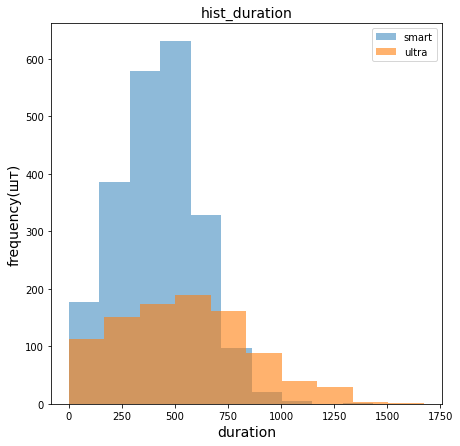

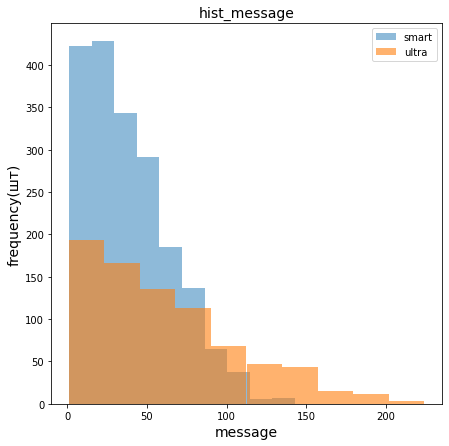

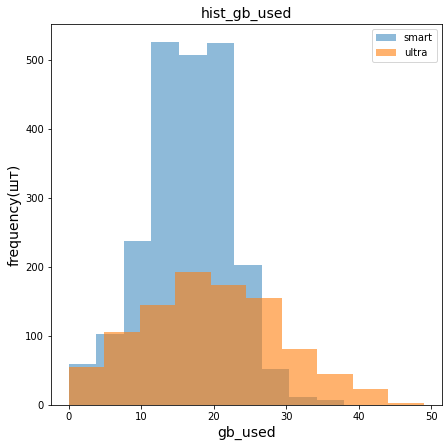

In [70]:
for column in ['duration', 'message', 'gb_used']:
    hist1 = df_smart[column]
    hist2 = df_ultra[column]
    fig, ax = plt.subplots(figsize=(7,7))
    ax.hist(hist1, alpha=0.5, label='smart')
    ax.hist(hist2, alpha=0.6, label='ultra')
    ax.legend()
    plt.title(f'hist_{column}', fontsize=14)
    plt.xlabel(column, fontsize=14)   
    plt.ylabel('frequency(шт)', fontsize=14);

На гистограммах длительности звонков и объема интернет-трафика обоих тарифов видим в целом нормальное распределение. Длительность звонков тарифа `Ультра` немного скошена вправо, это понятно и потому, что среднее немного, но больше медианы. Распределение количества сообщений на обоих тарифах прилично скошено вправо. Здесь среднее больше медианы. Все гистограммы тарифа `Ультра` также как и полученные выше дисперсии говорят нам о более широком разбросе значений по используемым средней длительности звонков, среднего количества сообщений и среднего объема интернет-трафика, иначе говоря пользователи более свободно пользуются услугами, в использовании услуг они отличаются от пользователей тарифа `Смарт`, где объем услуг в рамках абонентской платы существенно меньше. 

**Вывод**

Мы провели анализ поведения пользователей по двум тарифам исходя из выборки.  
По полученным данным выяснили, что количество клиентов использующих тариф `Смарт` более чем в два раза превышает количество клиентов, использующих тариф `Ультра`, 351 против 149.  
Общая выручка на тарифе `Смарт` -  2875901 рублей существенно превышает общую выручку от тарифа `Ультра` - 2041050 рублей, большинство пользователей использует тариф `Смарт`, это объяснимо, его абонентская плата 550 рублей за месяц  существенно ниже платы за месяц на тарифе `Ультра` 1950 рублей.   
Также мы видим что в среднем на тарифе `Смарт` пользователи укладываются в лимиты звонков(средняя длительность звонков - 419.1 мин), сообщений(среднее количество - 38.7) и интернет-трафика(средний объем - 16.3 Гб). Но в то же время существенной доли пользователей объемов услуг не хватает и они пользуются услагами сверх лимита. Какие то пользователи кому не хватает бесплатных лимитов тарифа `Смарт`, используют тариф `Ультра`. По полученным данным можно увидеть что в среднем они больше пользуются услугами связи: средняя длительность звонков - 545.5 мин; среднее количество сообщений - 61.2; средний объем интернет-трафика - 19.7 Гб. Возможности этого тарифа гораздо шире и разброс значений длительности звонков, количества сообщений и объема интернет-трафика здесь шире чем на тарифе `Смарт`. Также можно заметить, что клиенты тарифа `Ультра` в среднем используют объем звонков и сообщений существенно меньше верхней границы лимита, а вот объема интернет-трафика определенной доли клиентов не хватает. 

## 5. Проверка гипотез                                               <a id='intro6'></a>

1. Проверим гипотезу что средняя выручка пользователей тарифов `Ультра` и `Смарт` различается.

Выше мы уже создали два среза данных с выборками пользователей тарифа `Ультра` - `df_ultra` и тарифа `Смарт` - `df_smart`. Для того чтобы уточнить критерий проверки гипотез с помощью графиков посмотрим на распределение данных.

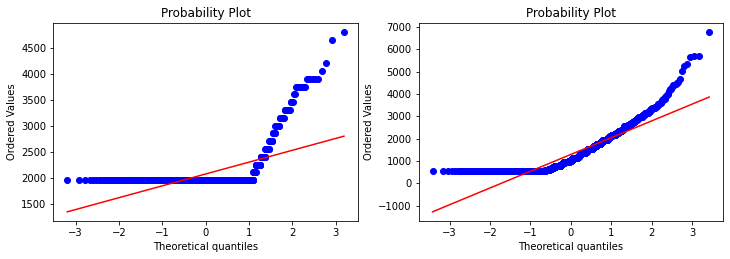

In [71]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(df_ultra['revenue_users'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(df_smart['revenue_users'], dist="norm", plot=plt)
plt.show()

Графики показывают ненормальное распределение и на первый взгляд нам не подходит параметрический критерий Стьюдента. Но согласно ЦПТ, если в выборке много наблюдений, распределение будет стремится к нормальному. Значит мы можем использовать критерий Стьюдента. 

<p>Введем основную и альтернативные гипотезы:</p>

H₀ сформулируем так, чтобы использовать знак равенства. Другими словами, чтобы все данные лежали в районе изначально предполагаемого значения.Исходя из H₀ сформулируем альтернативную гипотезу H₁. Это утверждение, которое принимается верным, если отбрасывается H₀.


$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние выручки пользователей тарифов 'Ультра' и 'Смарт' равны}\\
   H_1 :\text{Средние выручки пользователей тарифов 'Ультра' и 'Смарт' отличаются}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Посчитаем `p-value`, используя `ttest` из библиотеки `scipy` для сравнения средних двух выборок.

Если `p-value` будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

Применим метод `ttest_ind` к выручкам тарифов `Ультра` и `Смарт` для независимых выборок.

In [72]:
results = st.ttest_ind(df_ultra['revenue_users'], df_smart['revenue_users'], equal_var=False)
print('p-значение: ', results.pvalue)
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергаем гипотезу


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.927011394420941e-250
Отвергаем нулевую гипотезу


In [73]:
print(f'Средняя выручка пользователей тарифа "Ультра": {df_ultra.revenue_users.mean()}')
print(f'Средняя выручка пользователей тарифа "Смарт": {df_smart.revenue_users.mean()}')


Средняя выручка пользователей тарифа "Ультра": 2070.030425963489
Средняя выручка пользователей тарифа "Смарт": 1289.6417040358745


Итак, `p-value` получилось меньше выбранного уровня $\alpha = 0.05$. Отвергаем нулевую гипотезу - средние выручки пользователей тарифов 'Ультра' и 'Смарт' отличаются.

2. Проверим гипотезу что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Создадим срезы данных с пользователями из Москвы и с пользователями из других регионов с помощью `query`.

In [74]:
df_moskow = df_total.query('city == "Москва"')
df_regions = df_total.query('city != "Москва"')

Для того чтобы уточнить критерий проверки гипотез с помощью графиков посмотрим на распределение данных в датасетах с пользователями из Москвы `df_moskow` и датасетом со пользователями из других регионов `df_regions`.

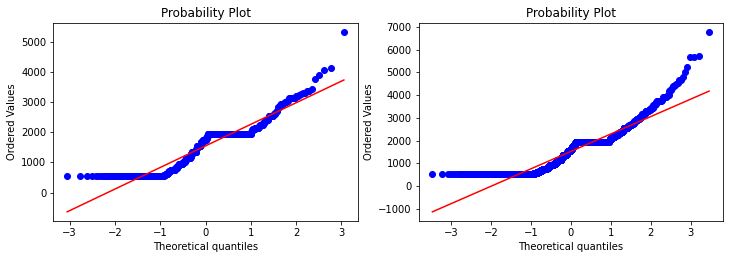

In [75]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(df_moskow['revenue_users'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(df_regions['revenue_users'], dist="norm", plot=plt);

Графики показывают ненормальное распределение, нам не подходит параметрический критерий Стьюдента. Но согласно ЦПТ, если в выборке много наблюдений, распределение будет стремится к нормальному. Значит мы можем использовать критерий Стьюдента. 

<p>Введем основную и альтернативные гипотезы:</p>

H₀ сформулируем так, чтобы использовать знак равенства. Другими словами, чтобы все данные лежали в районе изначально предполагаемого значения.Исходя из H₀ сформулируем альтернативную гипотезу H₁. Это утверждение, которое принимается верным, если отбрасывается H₀.


$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние выручки пользователей из Москвы и пользователей из других регионов равны}\\
   H_1 :\text{Средние выручки пользователей из Москвы и пользователей из других регионов отличаются}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Посчитаем `p-value`, используя `ttest` из библиотеки `scipy` для сравнения средних двух выборок.

Если `p-value` будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

Выполним расчет для выручек пользователей из Москвы и всех пользователей.
Здесь точно также применим метод `scipy.stats.ttest_ind()` для независимых выборок.

In [76]:
results = st.ttest_ind(df_moskow['revenue_users'], df_regions['revenue_users'], equal_var=False)
print('p-значение: ', results.pvalue)
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергаем гипотезу


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


In [77]:
print(f'Средняя выручка пользователей из Москвы: {df_moskow.revenue_users.mean()}')
print(f'Средняя выручка пользователей не из Москвы: {df_regions.revenue_users.mean()}')


Средняя выручка пользователей из Москвы: 1546.7135842880523
Средняя выручка пользователей не из Москвы: 1524.7251439539348


Итак, `p-value` получилось больше выбранного уровня $\alpha = 0.05$. Данные не позволили нам отвергнуть нулевую гипотезу - средние выручки пользователей из Москвы и пользователей из других регионов равны.

**Вывод**

Мы проверили две гипотезы:
- отвергнули нулевую гипотезу - средние выручки пользователей тарифов 'Ультра' и 'Смарт' отличаются (2070.03 против 1289.64), т.к. `p-value` получилось меньше выбранного уровня 0.05
- данные не позволили нам отвергнуть нулевую гипотезу - средние выручки пользователей из Москвы и пользователей из других регионов равны (1546.7 и 1524.7), т.к. `p-value` получилось больше выбранного уровня 0.05

## Общий вывод                                                                                    <a id='intro7'></a>

На основании полученных данных о пользователях двух тарифов «Смарт» и «Ультра» оператора сотовой связи мы изучили общую информацию о данных.  
В данных была произведена предобработка: 
- произведена замена типа данных для более удобного анализа и экономии памяти;
- поиск дубликатов в строках;

Рассчитали и добавили в таблицу несколько новых столбцов с параметрами, необходимыми для анализа.

Провели анализ поведения пользователей:
- Общая выручка на тарифе `Смарт` -  2875901 рублей существенно превышает общую выручку от тарифа `Ультра` - 2041050 рублей, большинство пользователей - 351 человек использует тариф `Смарт`, его абонентская плата 550 рублей за месяц  существенно ниже платы за месяц на тарифе `Ультра` 1950 рублей, который использует 149 человек.  Также мы узнали, что в среднем на тарифе `Смарт` пользователи укладываются в лимиты звонков(средняя длительность звонков - 419.1 мин), сообщений(среднее количество - 38.7) и интернет-трафика(средний объем - 16.3 Гб). Но существует большая доля пользователей, которым объема услуг не хватает и они используют услуги сверх лимита. Расчет средней выручки показал что клиенты тарифа `Смарт` переплачивают в среднем 740 рублей за услуги.  
- Клиенты использующие тариф `Ультра` в среднем больше пользуются услугами связи: средняя длительность звонков - 545.5 мин; среднее количество сообщений - 61.2; средний объем интернет-трафика - 19.7 Гб. Абсолютному большинству клиентов этого тарифа не требуется количество минут и сообщений, которое присутствует в пакете, а вот объема интернет-трафика некоторой доли пользователей не хватает. Возможно тариф стоит переработать в сторону уменьшения порогов количества минут и сообщений и увеличения объема интернет-трафика. Это может привлечь дополнительных клиентов.

Проверили две гипотезы:
- отвергнули нулевую гипотезу - средние выручки пользователей тарифов 'Ультра' и 'Смарт' отличаются(2070.03 против 1289.64), т.к. `p-value` получилось меньше выбранного уровня 0.05
- данные не позволили нам отвергнуть нулевую гипотезу - средние выручки пользователей из Москвы и пользователей из других регионов равны(1546.7 и 1524.7), т.к. `p-value` получилось больше выбранного уровня 0.05

В итоге, данные нам говорят о том, что тариф `Ультра` более прибыльный для компании чем тариф `Смарт`, несмотря на то что исходя из выборки его выбирает мешьшее количество клиентов прибыль от одного клиента с этого тарифа заметно выше. Плюс у этого тарифа есть потенциал для изменения и расширения услуг.